In [30]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib pandas pyarrow wandb

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/8b/8d/bb05a4ecdeac6b2256d98ac10bae8723af5d7a8c1a4c2384b3ae0f80370e/wandb-0.16.6-py3-none-any.whl.metadata
  Obtaining dependency information for Click!=8.0.0,>=7.1 from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
  Obtaining dependency information for GitPython!=3.1.29,>=1.0.0 from https://files.pythonhosted.org/packages/e9/bd/cc3a402a6439c15c3d4294333e13042b915bbeab54edc457c723931fed3f/GitPython-3.1.43-py3-none-any.whl.metadata
  Obtaining dependency information for sentry-sdk>=1.0.0 from https://files.pythonhosted.org/packages/b1/f8/2038661bc32579d0c11191fc1093e49db590bfb6e63d501d7995fb798d62/sentry_sdk-1.44.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for docker-pycreds>=0.4.0 from https://files.pythonhosted.org/packages/f5/e8/f6bd1eee09314e7e6dee49cbe2c5e22314ccdb38db16c9f

In [31]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import time
import wandb

In [11]:
class CONFIG:
    # root = os.path.join("/", "kaggle", "input", "asl-signs") 
    root = os.path.join(".")
    DATA_LIMIT = 100
    BATCH_SIZE = 8
    VIDEO_LENGTH = 60
    TRAIN_VAL_SPLIT = 0.9
    WANDB_RUN = "mediapipe-asl-dataset"

In [12]:
os.listdir(CONFIG.root)

['asl-signs.zip',
 'lstm-approach.ipynb',
 '.ipynb_checkpoints',
 'sign_to_prediction_index_map.json',
 'train.csv',
 'train_landmark_files']

In [13]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np

ids = None

order_global = {"pose" : 10000, "face" : 1000, "left_hand" : 100, "right_hand" : 10}

def process_parquet(ds):
    ret = []
    frames_unique = sorted(np.unique(ds["frame"]))
    for i,frame in enumerate(frames_unique):
        frame_ds = ds[ds['frame'] == frame]
        
        order = []
        for el in frame_ds["row_id"]:
            _frame, part, keypoint = el.split("-")
            order.append(order_global[part] - int(keypoint))

        order = np.array(order)
        frame_ds.iloc[:, 1] = order
        frame_ds = frame_ds.sort_values(by="row_id", ascending=False)
    
        vals = np.array(frame_ds[["x", "y", "z"]]).flatten()

        ret.append(vals)
    return np.array(ret)
        
#process_parquet("79631423.parquet")

In [25]:
from sklearn.model_selection import train_test_split

#custom class to load data from Parquet files for training ML models.
class ParquetDataset(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 preprocessing_func=None, frame_length :int = CONFIG.VIDEO_LENGTH,
                 split : str = "train", train_val_split : float = CONFIG.TRAIN_VAL_SPLIT,
                 sort_by_counts : bool = True, **kwargs
                ):
        super().__init__(**kwargs)
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.preprocessing_func = preprocessing_func
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        
        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        np.random.shuffle(self.dataset)
                   

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return math.ceil(len(self.dataset) / self.batch_size)
    
    def get_single(self, idx):
        # Load one file per batch
        #take the idx value, 1st label, 
        path, label = self.dataset[idx]
        
        df = pd.read_parquet( path)
        
        # Apply preprocessing if specified
        if self.preprocessing_func:
            df = self.preprocessing_func(df, self.frame_length)
        
        one_hot_encoded_label = np.zeros(len(self.unique_labels))
        one_hot_encoded_label[self.label_2_id[label]] = 1  
        
        return df, one_hot_encoded_label

    def __getitem__(self, idx):
        X, Y = [], []
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.dataset))
        
        for i in range(low, high):
            x, y = self.get_single(i)
            X.append(x)
            Y.append(y)
        
        return np.array(X), np.array(Y)
                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)

def my_preprocessing_func(df, frame_length):
    
    # Define your preprocessing steps here
    # Example: normalize numerical features
    frames_mediapipe = process_parquet(df)
    
    current_length, num_features = frames_mediapipe.shape

    if current_length >= frame_length:
            # TODO: a better than uniform value ? Could place gaussian in the middle
            random_start = random.randint(0, current_length - frame_length)
            return np.nan_to_num(frames_mediapipe[random_start : (random_start + frame_length)])
        
    # padd the video to contain zeros 
    return np.concatenate([np.nan_to_num(frames_mediapipe), np.zeros((frame_length - current_length, num_features))], axis=0)
    
# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=1000,
                                 preprocessing_func=my_preprocessing_func,
                                check_if_file_exists = True,
                                split="train")

val_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=1000,
                                 preprocessing_func=my_preprocessing_func,
                                 check_if_file_exists= True,
                                 split="val")

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

100%|██████████| 94477/94477 [00:00<00:00, 254670.17it/s]


cardinality of train : 113, cardinality of validation : 13


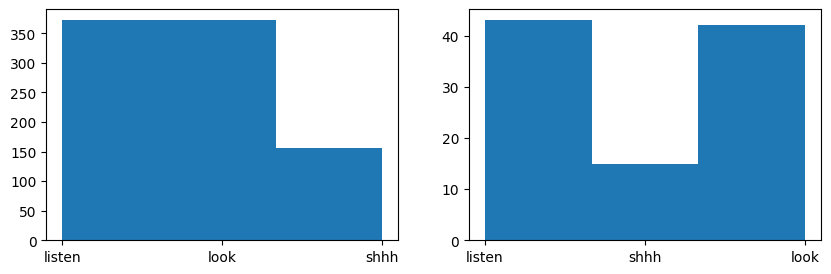

In [26]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataset_parquet.dataset[:, 1], bins=len(train_dataset_parquet.unique_labels))

plt.subplot(1, 2, 2)
plt.hist(val_dataset_parquet.dataset[:, 1], bins=len(val_dataset_parquet.unique_labels))

plt.show()

In [27]:
start = time.time()
isnans =False

f = True
labels_batches = []
for el in tqdm(train_dataset_parquet):
    if f:
        print(el[0].shape, el[1].shape)
        f = False
    labels_batches.append(el[1])
        
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break


print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")

  1%|          | 1/113 [00:00<00:46,  2.39it/s]

(8, 60, 1629) (8, 3)


100%|██████████| 113/113 [00:40<00:00,  2.78it/s]

Iterating through dataset took : 40.6401s


# Train experiment

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=50, epochs=100, run_name="", mediapipe_features = "all",): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    wandb.init(project=CONFIG.WANDB_RUN,
                     name=run_name,
                     notes="Model summary : \n" + str(model),
                     config={"max_lr" : max_lr, 
                             "min_lr" : 5e-5, 
                             "scheduler" : "cosineAnnealer", 
                             "epochs" : epochs, 
                             "T_max" : T_max, 
                             "train_size" : len(train_dataset_parquet.dataset),
                             "val_size" : len(val_dataset_parquet.dataset),
                             "unique_classes" : len(train_dataset_parquet.unique_labels), 
                             "video_length" : CONFIG.VIDEO_LENGTH,
                             "features" : mediapipe_features
                             })
    history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, 
                        batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    
    wandb.finish()
    
    return history

# Train simple LSTM

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM1.keras"),
            run_name="LSTM128-Dense128-Dense256-allfeatures")

Epoch 1/100
113/113 [==============================] - 50s 420ms/step - loss: 1.1593 - categorical_accuracy: 0.4256 - val_loss: 1.1256 - val_categorical_accuracy: 0.4400
Epoch 2/100
113/113 [==============================] - 47s 419ms/step - loss: 1.1167 - categorical_accuracy: 0.4033 - val_loss: 1.0833 - val_categorical_accuracy: 0.4100
Epoch 3/100
113/113 [==============================] - 47s 418ms/step - loss: 1.0962 - categorical_accuracy: 0.3978 - val_loss: 1.0736 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - 47s 418ms/step - loss: 1.0673 - categorical_accuracy: 0.4167 - val_loss: 1.0816 - val_categorical_accuracy: 0.4300
Epoch 5/100
113/113 [==============================] - 48s 429ms/step - loss: 1.0626 - categorical_accuracy: 0.4289 - val_loss: 1.0159 - val_categorical_accuracy: 0.5600
Epoch 6/100
113/113 [==============================] - 47s 421ms/step - loss: 1.0114 - categorical_accuracy: 0.4800 - val_loss: 0.9312 - val_categoric

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM1.tf"),
            run_name="LSTM64-Dense128-Dense256-allfeatures")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM256-Dense128-Dense256-allfeatures.tf"),
            run_name="LSTM256-Dense128-Dense256-allfeatures")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM128-Dense256-allfeatures.tf"),
            run_name="LSTM128-Dense256-allfeatures")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM128-Dense128-allfeatures.tf"),
            run_name="LSTM128-Dense128-allfeatures")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0000001), 
               activity_regularizer=l2(0.0000001)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


0keras_train(model, filepath=os.path.join("models", "LSTM128_l2-Dense128-Dense256-allfeatures.tf"),
            run_name="LSTM128_l2-Dense128-Dense256-allfeatures")

In [46]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.005), 
               activity_regularizer=l2(0.005)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM-L64-D128-D256-reg=0.005.tf"),
            run_name="LSTM64-Dense128-Dense256-allfeatures_bigger_reg")

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.36889
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,2.82214
epoch/val_categorical_accuracy,0.45


Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 2.8411 - categorical_accuracy: 0.4000INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 60s 499ms/step - loss: 2.8411 - categorical_accuracy: 0.4000 - val_loss: 2.4088 - val_categorical_accuracy: 0.4200
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 2.1274 - categorical_accuracy: 0.4056INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 502ms/step - loss: 2.1274 - categorical_accuracy: 0.4056 - val_loss: 1.8624 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 49s 439ms/step - loss: 1.7043 - categorical_accuracy: 0.4044 - val_loss: 1.5451 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - 50s 445ms/step - loss: 1.4585 - categorical_accuracy: 0.4056 - val_loss: 1.3563 - val_categorical_accuracy: 0.4400
Epoch 5/100
113/113 [==============================] - 50s 441ms/step - loss: 1.3106 - categorical_accuracy: 0.4056 - val_loss: 1.2412 - val_categorical_accuracy: 0.4300
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 1.2187 - categorical_accuracy: 0.4167INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 1.2187 - categorical_accuracy: 0.4167 - val_loss: 1.1653 - val_categorical_accuracy: 0.4200
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 1.1668 - categorical_accuracy: 0.4211INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 1.1668 - categorical_accuracy: 0.4211 - val_loss: 1.0656 - val_categorical_accuracy: 0.5000
Epoch 8/100
113/113 [==============================] - 50s 442ms/step - loss: 1.1402 - categorical_accuracy: 0.4167 - val_loss: 1.0608 - val_categorical_accuracy: 0.5100
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 1.0638 - categorical_accuracy: 0.4833INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 1.0638 - categorical_accuracy: 0.4833 - val_loss: 0.9921 - val_categorical_accuracy: 0.5600
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 1.0240 - categorical_accuracy: 0.4889INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 500ms/step - loss: 1.0240 - categorical_accuracy: 0.4889 - val_loss: 1.0163 - val_categorical_accuracy: 0.5200
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 1.0002 - categorical_accuracy: 0.5100INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 1.0002 - categorical_accuracy: 0.5100 - val_loss: 0.9776 - val_categorical_accuracy: 0.5200
Epoch 12/100
113/113 [==============================] - ETA: 0s - loss: 0.9623 - categorical_accuracy: 0.5144INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.9623 - categorical_accuracy: 0.5144 - val_loss: 0.9214 - val_categorical_accuracy: 0.5500
Epoch 13/100
113/113 [==============================] - ETA: 0s - loss: 0.9209 - categorical_accuracy: 0.5544INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.9209 - categorical_accuracy: 0.5544 - val_loss: 0.8942 - val_categorical_accuracy: 0.5600
Epoch 14/100
113/113 [==============================] - 50s 446ms/step - loss: 0.9315 - categorical_accuracy: 0.5333 - val_loss: 0.9100 - val_categorical_accuracy: 0.5400
Epoch 15/100
113/113 [==============================] - ETA: 0s - loss: 0.8799 - categorical_accuracy: 0.5733INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.8799 - categorical_accuracy: 0.5733 - val_loss: 0.8732 - val_categorical_accuracy: 0.5500
Epoch 16/100
113/113 [==============================] - 50s 443ms/step - loss: 0.8731 - categorical_accuracy: 0.5589 - val_loss: 0.8565 - val_categorical_accuracy: 0.5900
Epoch 17/100
113/113 [==============================] - 50s 447ms/step - loss: 0.8757 - categorical_accuracy: 0.5556 - val_loss: 0.8595 - val_categorical_accuracy: 0.5800
Epoch 18/100
113/113 [==============================] - 50s 444ms/step - loss: 0.8616 - categorical_accuracy: 0.5733 - val_loss: 0.8362 - val_categorical_accuracy: 0.6100
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.8751 - categorical_accuracy: 0.5800INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.8751 - categorical_accuracy: 0.5800 - val_loss: 0.8408 - val_categorical_accuracy: 0.5700
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.8239 - categorical_accuracy: 0.6022INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 502ms/step - loss: 0.8239 - categorical_accuracy: 0.6022 - val_loss: 0.8111 - val_categorical_accuracy: 0.6000
Epoch 21/100
113/113 [==============================] - ETA: 0s - loss: 0.8207 - categorical_accuracy: 0.6067INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 511ms/step - loss: 0.8207 - categorical_accuracy: 0.6067 - val_loss: 0.8012 - val_categorical_accuracy: 0.6100
Epoch 22/100
113/113 [==============================] - ETA: 0s - loss: 0.7945 - categorical_accuracy: 0.6511INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.7945 - categorical_accuracy: 0.6511 - val_loss: 0.7536 - val_categorical_accuracy: 0.6500
Epoch 23/100
113/113 [==============================] - 50s 443ms/step - loss: 0.7951 - categorical_accuracy: 0.6400 - val_loss: 0.9351 - val_categorical_accuracy: 0.6400
Epoch 24/100
113/113 [==============================] - 50s 449ms/step - loss: 0.8354 - categorical_accuracy: 0.6267 - val_loss: 1.3834 - val_categorical_accuracy: 0.3300
Epoch 25/100
113/113 [==============================] - ETA: 0s - loss: 0.7755 - categorical_accuracy: 0.6633INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 499ms/step - loss: 0.7755 - categorical_accuracy: 0.6633 - val_loss: 0.7559 - val_categorical_accuracy: 0.6800
Epoch 26/100
113/113 [==============================] - ETA: 0s - loss: 0.7431 - categorical_accuracy: 0.7156INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.7431 - categorical_accuracy: 0.7156 - val_loss: 0.8453 - val_categorical_accuracy: 0.5700
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 0.7037 - categorical_accuracy: 0.7278INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 502ms/step - loss: 0.7037 - categorical_accuracy: 0.7278 - val_loss: 0.7106 - val_categorical_accuracy: 0.7100
Epoch 28/100
113/113 [==============================] - ETA: 0s - loss: 0.6386 - categorical_accuracy: 0.7778INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 502ms/step - loss: 0.6386 - categorical_accuracy: 0.7778 - val_loss: 0.7482 - val_categorical_accuracy: 0.6600
Epoch 29/100
113/113 [==============================] - 50s 445ms/step - loss: 0.6493 - categorical_accuracy: 0.7622 - val_loss: 0.5469 - val_categorical_accuracy: 0.8400
Epoch 30/100
113/113 [==============================] - 50s 441ms/step - loss: 0.6398 - categorical_accuracy: 0.7711 - val_loss: 0.5749 - val_categorical_accuracy: 0.7700
Epoch 31/100
113/113 [==============================] - ETA: 0s - loss: 0.6062 - categorical_accuracy: 0.7833INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.6062 - categorical_accuracy: 0.7833 - val_loss: 0.7759 - val_categorical_accuracy: 0.6900
Epoch 32/100
113/113 [==============================] - ETA: 0s - loss: 0.5734 - categorical_accuracy: 0.8022INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.5734 - categorical_accuracy: 0.8022 - val_loss: 0.6057 - val_categorical_accuracy: 0.7800
Epoch 33/100
113/113 [==============================] - ETA: 0s - loss: 0.5675 - categorical_accuracy: 0.8044INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 506ms/step - loss: 0.5675 - categorical_accuracy: 0.8044 - val_loss: 0.7343 - val_categorical_accuracy: 0.7800
Epoch 34/100
113/113 [==============================] - 50s 446ms/step - loss: 0.5910 - categorical_accuracy: 0.7911 - val_loss: 0.5328 - val_categorical_accuracy: 0.8200
Epoch 35/100
113/113 [==============================] - 51s 450ms/step - loss: 0.6100 - categorical_accuracy: 0.7944 - val_loss: 0.9632 - val_categorical_accuracy: 0.7100
Epoch 36/100
113/113 [==============================] - 50s 445ms/step - loss: 0.6669 - categorical_accuracy: 0.7811 - val_loss: 0.5713 - val_categorical_accuracy: 0.8100
Epoch 37/100
113/113 [==============================] - 50s 447ms/step - loss: 0.5737 - categorical_accuracy: 0.8033 - val_loss: 0.8288 - val_categorical_accuracy: 0.6900
Epoch 38/100
113/113 [==============================] - ETA: 0s - loss: 0.5330 - categorical_accuracy: 0.8344INFO:tensorflow:Assets written to: models/LSTM-L6

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.5330 - categorical_accuracy: 0.8344 - val_loss: 0.8726 - val_categorical_accuracy: 0.6300
Epoch 39/100
113/113 [==============================] - 50s 447ms/step - loss: 0.5579 - categorical_accuracy: 0.8111 - val_loss: 0.7435 - val_categorical_accuracy: 0.7500
Epoch 40/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5458 - categorical_accuracy: 0.8233 - val_loss: 0.8340 - val_categorical_accuracy: 0.7000
Epoch 41/100
113/113 [==============================] - 51s 449ms/step - loss: 0.6143 - categorical_accuracy: 0.7856 - val_loss: 0.7396 - val_categorical_accuracy: 0.7700
Epoch 42/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5929 - categorical_accuracy: 0.7967 - val_loss: 0.7475 - val_categorical_accuracy: 0.6900
Epoch 43/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5422 - categorical_accuracy: 0.8333 - val_loss: 0.6000 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 507ms/step - loss: 0.4798 - categorical_accuracy: 0.8567 - val_loss: 0.6378 - val_categorical_accuracy: 0.7800
Epoch 45/100
113/113 [==============================] - 49s 438ms/step - loss: 0.5517 - categorical_accuracy: 0.8100 - val_loss: 0.6610 - val_categorical_accuracy: 0.8000
Epoch 46/100
113/113 [==============================] - 50s 444ms/step - loss: 0.5207 - categorical_accuracy: 0.8422 - val_loss: 0.5422 - val_categorical_accuracy: 0.8600
Epoch 47/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5088 - categorical_accuracy: 0.8489 - val_loss: 0.5806 - val_categorical_accuracy: 0.7900
Epoch 48/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5605 - categorical_accuracy: 0.8167 - val_loss: 0.4904 - val_categorical_accuracy: 0.8400
Epoch 49/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5473 - categorical_accuracy: 0.8278 - val_loss: 0.6565 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.4259 - categorical_accuracy: 0.8800 - val_loss: 0.6574 - val_categorical_accuracy: 0.7800
Epoch 56/100
113/113 [==============================] - 51s 446ms/step - loss: 0.5203 - categorical_accuracy: 0.8444 - val_loss: 0.5315 - val_categorical_accuracy: 0.8300
Epoch 57/100
113/113 [==============================] - 51s 448ms/step - loss: 0.5094 - categorical_accuracy: 0.8478 - val_loss: 0.6249 - val_categorical_accuracy: 0.8100
Epoch 58/100
113/113 [==============================] - 51s 447ms/step - loss: 0.5697 - categorical_accuracy: 0.8200 - val_loss: 0.4367 - val_categorical_accuracy: 0.9000
Epoch 59/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4575 - categorical_accuracy: 0.8767 - val_loss: 0.6292 - val_categorical_accuracy: 0.8000
Epoch 65/100
113/113 [==============================] - 50s 447ms/step - loss: 0.4987 - categorical_accuracy: 0.8511 - val_loss: 0.5974 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 513ms/step - loss: 0.4312 - categorical_accuracy: 0.8878 - val_loss: 0.4676 - val_categorical_accuracy: 0.8600
Epoch 74/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4691 - categorical_accuracy: 0.8589 - val_loss: 0.4604 - val_categorical_accuracy: 0.8700
Epoch 75/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4864 - categorical_accuracy: 0.8567 - val_loss: 0.4465 - val_categorical_accuracy: 0.9000
Epoch 76/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4778 - categorical_accuracy: 0.8678 - val_loss: 0.4316 - val_categorical_accuracy: 0.8800
Epoch 77/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4969 - categorical_accuracy: 0.8444 - val_loss: 0.4481 - val_categorical_accuracy: 0.8800
Epoch 78/100
113/113 [==============================] - 50s 448ms/step - loss: 0.4584 - categorical_accuracy: 0.8644 - val_loss: 0.4431 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.4070 - categorical_accuracy: 0.8900 - val_loss: 0.4321 - val_categorical_accuracy: 0.8800
Epoch 80/100
113/113 [==============================] - 50s 442ms/step - loss: 0.4880 - categorical_accuracy: 0.8633 - val_loss: 0.4699 - val_categorical_accuracy: 0.8800
Epoch 81/100
113/113 [==============================] - 50s 439ms/step - loss: 0.4324 - categorical_accuracy: 0.8822 - val_loss: 0.4674 - val_categorical_accuracy: 0.8600
Epoch 82/100
113/113 [==============================] - 50s 439ms/step - loss: 0.4607 - categorical_accuracy: 0.8722 - val_loss: 0.4195 - val_categorical_accuracy: 0.9000
Epoch 83/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5813 - categorical_accuracy: 0.8144 - val_loss: 0.7107 - val_categorical_accuracy: 0.8300
Epoch 84/100
113/113 [==============================] - 50s 440ms/step - loss: 0.5578 - categorical_accuracy: 0.8311 - val_loss: 0.4452 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 498ms/step - loss: 0.4063 - categorical_accuracy: 0.8922 - val_loss: 0.4536 - val_categorical_accuracy: 0.8800
Epoch 95/100
113/113 [==============================] - 51s 444ms/step - loss: 0.4751 - categorical_accuracy: 0.8656 - val_loss: 0.5127 - val_categorical_accuracy: 0.8400
Epoch 96/100
113/113 [==============================] - 50s 442ms/step - loss: 0.4397 - categorical_accuracy: 0.8767 - val_loss: 0.4737 - val_categorical_accuracy: 0.8700
Epoch 97/100
113/113 [==============================] - 50s 445ms/step - loss: 0.4376 - categorical_accuracy: 0.8722 - val_loss: 0.4013 - val_categorical_accuracy: 0.8800
Epoch 98/100
113/113 [==============================] - 50s 443ms/step - loss: 0.4417 - categorical_accuracy: 0.8722 - val_loss: 0.4582 - val_categorical_accuracy: 0.8600
Epoch 99/100
113/113 [==============================] - 50s 441ms/step - loss: 0.4192 - categorical_accuracy: 0.8867 - val_loss: 0.4077 - val_categorical_accu

epoch/categorical_accuracy,▁▁▁▁▃▃▃▃▄▄▅▆▆▇▆▇▆▇▇▇▇▇▇█▇█▇▇▇█▇██▇▇████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▂▂▃▃▄▄▄▃▅▅▇▇▆▆▆▇▆▅▅▇▇▇▇▇▇▇█████▇████▇
epoch/val_loss,█▅▄▃▃▃▃▃▂▃▃▂▂▁▂▂▂▂▁▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch/categorical_accuracy,0.84667
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.50475
epoch/val_categorical_accuracy,0.8


In [49]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM128-Dense128-Dense256-allfeatures.tf"),
            run_name="LSTM128-Dense128-Dense256-allfeatures")

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1593 - categorical_accuracy: 0.4111INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 59s 497ms/step - loss: 1.1593 - categorical_accuracy: 0.4111 - val_loss: 1.1264 - val_categorical_accuracy: 0.4300
Epoch 2/100
113/113 [==============================] - 50s 440ms/step - loss: 1.1159 - categorical_accuracy: 0.4122 - val_loss: 1.0794 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 50s 444ms/step - loss: 1.0872 - categorical_accuracy: 0.4156 - val_loss: 1.0639 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0789 - categorical_accuracy: 0.4222INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 504ms/step - loss: 1.0789 - categorical_accuracy: 0.4222 - val_loss: 1.0364 - val_categorical_accuracy: 0.4500
Epoch 5/100
113/113 [==============================] - ETA: 0s - loss: 1.0382 - categorical_accuracy: 0.4522INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 504ms/step - loss: 1.0382 - categorical_accuracy: 0.4522 - val_loss: 0.9582 - val_categorical_accuracy: 0.4800
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.9295 - categorical_accuracy: 0.5167INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 56s 500ms/step - loss: 0.9295 - categorical_accuracy: 0.5167 - val_loss: 0.8747 - val_categorical_accuracy: 0.5400
Epoch 7/100
113/113 [==============================] - 50s 445ms/step - loss: 0.8825 - categorical_accuracy: 0.5411 - val_loss: 0.8312 - val_categorical_accuracy: 0.5300
Epoch 8/100
113/113 [==============================] - ETA: 0s - loss: 0.8269 - categorical_accuracy: 0.5622INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 58s 509ms/step - loss: 0.8269 - categorical_accuracy: 0.5622 - val_loss: 0.8254 - val_categorical_accuracy: 0.5500
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.8556 - categorical_accuracy: 0.5433INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 507ms/step - loss: 0.8556 - categorical_accuracy: 0.5433 - val_loss: 0.8159 - val_categorical_accuracy: 0.6200
Epoch 10/100
113/113 [==============================] - 50s 446ms/step - loss: 0.8348 - categorical_accuracy: 0.5756 - val_loss: 0.7958 - val_categorical_accuracy: 0.5500
Epoch 11/100
113/113 [==============================] - 50s 442ms/step - loss: 0.8885 - categorical_accuracy: 0.5233 - val_loss: 0.9448 - val_categorical_accuracy: 0.5100
Epoch 12/100
113/113 [==============================] - 50s 447ms/step - loss: 0.8151 - categorical_accuracy: 0.5722 - val_loss: 0.8031 - val_categorical_accuracy: 0.5500
Epoch 13/100
113/113 [==============================] - 50s 445ms/step - loss: 0.7978 - categorical_accuracy: 0.5844 - val_loss: 0.8093 - val_categorical_accuracy: 0.5400
Epoch 14/100
113/113 [==============================] - 50s 444ms/step - loss: 0.7737 - categorical_accuracy: 0.5944 - val_loss: 0.7904 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 506ms/step - loss: 0.7333 - categorical_accuracy: 0.6744 - val_loss: 0.7445 - val_categorical_accuracy: 0.6900
Epoch 18/100
113/113 [==============================] - ETA: 0s - loss: 0.6788 - categorical_accuracy: 0.7311INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 0.6788 - categorical_accuracy: 0.7311 - val_loss: 0.6787 - val_categorical_accuracy: 0.7300
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.6468 - categorical_accuracy: 0.7200INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.6468 - categorical_accuracy: 0.7200 - val_loss: 0.5513 - val_categorical_accuracy: 0.8400
Epoch 20/100
113/113 [==============================] - 51s 448ms/step - loss: 0.6418 - categorical_accuracy: 0.7500 - val_loss: 0.5769 - val_categorical_accuracy: 0.7900
Epoch 21/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5473 - categorical_accuracy: 0.8067 - val_loss: 0.5113 - val_categorical_accuracy: 0.8200
Epoch 22/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5497 - categorical_accuracy: 0.8022 - val_loss: 0.4657 - val_categorical_accuracy: 0.8200
Epoch 23/100
113/113 [==============================] - ETA: 0s - loss: 0.5541 - categorical_accuracy: 0.7900INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 509ms/step - loss: 0.5541 - categorical_accuracy: 0.7900 - val_loss: 0.5049 - val_categorical_accuracy: 0.8500
Epoch 24/100
113/113 [==============================] - 50s 444ms/step - loss: 0.5154 - categorical_accuracy: 0.7989 - val_loss: 0.5346 - val_categorical_accuracy: 0.7900
Epoch 25/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5237 - categorical_accuracy: 0.8133 - val_loss: 0.4664 - val_categorical_accuracy: 0.8300
Epoch 26/100
113/113 [==============================] - 50s 446ms/step - loss: 0.5831 - categorical_accuracy: 0.8033 - val_loss: 0.5966 - val_categorical_accuracy: 0.8000
Epoch 27/100
113/113 [==============================] - 50s 445ms/step - loss: 0.5225 - categorical_accuracy: 0.8033 - val_loss: 0.7948 - val_categorical_accuracy: 0.7300
Epoch 28/100
113/113 [==============================] - 50s 446ms/step - loss: 0.5959 - categorical_accuracy: 0.7822 - val_loss: 0.6207 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.4713 - categorical_accuracy: 0.8367 - val_loss: 0.4706 - val_categorical_accuracy: 0.8600
Epoch 30/100
113/113 [==============================] - 50s 443ms/step - loss: 0.4891 - categorical_accuracy: 0.8333 - val_loss: 0.4781 - val_categorical_accuracy: 0.8400
Epoch 31/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5176 - categorical_accuracy: 0.8200 - val_loss: 0.5093 - val_categorical_accuracy: 0.8400
Epoch 32/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4791 - categorical_accuracy: 0.8400 - val_loss: 0.4815 - val_categorical_accuracy: 0.8500
Epoch 33/100
113/113 [==============================] - 50s 448ms/step - loss: 0.4326 - categorical_accuracy: 0.8689 - val_loss: 0.5219 - val_categorical_accuracy: 0.8000
Epoch 34/100
113/113 [==============================] - ETA: 0s - loss: 0.4221 - categorical_accuracy: 0.8611INFO:tensorflow:Assets written to: models/LSTM128

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 509ms/step - loss: 0.4221 - categorical_accuracy: 0.8611 - val_loss: 0.4338 - val_categorical_accuracy: 0.8700
Epoch 35/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4176 - categorical_accuracy: 0.8600 - val_loss: 0.5111 - val_categorical_accuracy: 0.8100
Epoch 36/100
113/113 [==============================] - 50s 441ms/step - loss: 0.3978 - categorical_accuracy: 0.8722 - val_loss: 0.4874 - val_categorical_accuracy: 0.8100
Epoch 37/100
113/113 [==============================] - ETA: 0s - loss: 0.4454 - categorical_accuracy: 0.8511INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 504ms/step - loss: 0.4454 - categorical_accuracy: 0.8511 - val_loss: 0.3816 - val_categorical_accuracy: 0.8900
Epoch 38/100
113/113 [==============================] - 49s 437ms/step - loss: 0.3786 - categorical_accuracy: 0.8889 - val_loss: 0.4801 - val_categorical_accuracy: 0.8500
Epoch 39/100
113/113 [==============================] - 50s 443ms/step - loss: 0.3902 - categorical_accuracy: 0.8922 - val_loss: 0.5937 - val_categorical_accuracy: 0.8000
Epoch 40/100
113/113 [==============================] - 50s 441ms/step - loss: 0.3852 - categorical_accuracy: 0.8889 - val_loss: 0.4676 - val_categorical_accuracy: 0.8500
Epoch 41/100
113/113 [==============================] - 50s 445ms/step - loss: 0.3807 - categorical_accuracy: 0.8856 - val_loss: 0.4871 - val_categorical_accuracy: 0.8300
Epoch 42/100
113/113 [==============================] - 50s 444ms/step - loss: 0.3750 - categorical_accuracy: 0.8822 - val_loss: 0.4893 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 56s 499ms/step - loss: 0.3903 - categorical_accuracy: 0.8844 - val_loss: 0.3689 - val_categorical_accuracy: 0.9000
Epoch 46/100
113/113 [==============================] - 50s 446ms/step - loss: 0.3459 - categorical_accuracy: 0.9078 - val_loss: 0.3768 - val_categorical_accuracy: 0.9000
Epoch 47/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3704 - categorical_accuracy: 0.8956 - val_loss: 0.4289 - val_categorical_accuracy: 0.8800
Epoch 48/100
113/113 [==============================] - 50s 445ms/step - loss: 0.3126 - categorical_accuracy: 0.9122 - val_loss: 0.4029 - val_categorical_accuracy: 0.8800
Epoch 49/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3530 - categorical_accuracy: 0.8922 - val_loss: 0.4759 - val_categorical_accuracy: 0.8700
Epoch 50/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4171 - categorical_accuracy: 0.8767 - val_loss: 0.6324 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 506ms/step - loss: 0.2845 - categorical_accuracy: 0.9200 - val_loss: 0.3175 - val_categorical_accuracy: 0.9200
Epoch 79/100
113/113 [==============================] - 51s 455ms/step - loss: 0.3147 - categorical_accuracy: 0.9156 - val_loss: 0.3852 - val_categorical_accuracy: 0.8900
Epoch 80/100
113/113 [==============================] - 51s 448ms/step - loss: 0.2673 - categorical_accuracy: 0.9200 - val_loss: 0.3926 - val_categorical_accuracy: 0.9000
Epoch 81/100
113/113 [==============================] - 51s 452ms/step - loss: 0.2707 - categorical_accuracy: 0.9256 - val_loss: 0.3431 - val_categorical_accuracy: 0.9000
Epoch 82/100
  6/113 [>.............................] - ETA: 38s - loss: 0.2516 - categorical_accuracy: 0.9375

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [53]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM64-Dense64-allfeatures.tf"),
            run_name="LSTM64-Dense64-allfeatures", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.41667
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,1.13316
epoch/val_categorical_accuracy,0.44


Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1343 - categorical_accuracy: 0.4444INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 59s 497ms/step - loss: 1.1343 - categorical_accuracy: 0.4444 - val_loss: 1.1175 - val_categorical_accuracy: 0.4300
Epoch 2/100
113/113 [==============================] - 51s 450ms/step - loss: 1.1170 - categorical_accuracy: 0.4256 - val_loss: 1.0923 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 52s 454ms/step - loss: 1.0976 - categorical_accuracy: 0.4200 - val_loss: 1.0688 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - 51s 455ms/step - loss: 1.0772 - categorical_accuracy: 0.4267 - val_loss: 1.0476 - val_categorical_accuracy: 0.4300
Epoch 5/100
113/113 [==============================] - 51s 452ms/step - loss: 1.0660 - categorical_accuracy: 0.4222 - val_loss: 1.0532 - val_categorical_accuracy: 0.4300
Epoch 6/100
113/113 [==============================] - 52s 458ms/step - loss: 1.0527 - categorical_accuracy: 0.4122 - val_loss: 1.0162 - val_categorical_accuracy:

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 518ms/step - loss: 1.0104 - categorical_accuracy: 0.4322 - val_loss: 0.9230 - val_categorical_accuracy: 0.5300
Epoch 8/100
113/113 [==============================] - 51s 449ms/step - loss: 0.9788 - categorical_accuracy: 0.4911 - val_loss: 1.0028 - val_categorical_accuracy: 0.4700
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.9554 - categorical_accuracy: 0.5089INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.9554 - categorical_accuracy: 0.5089 - val_loss: 0.9205 - val_categorical_accuracy: 0.5400
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.8856 - categorical_accuracy: 0.5389INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 514ms/step - loss: 0.8856 - categorical_accuracy: 0.5389 - val_loss: 0.8232 - val_categorical_accuracy: 0.5600
Epoch 11/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8843 - categorical_accuracy: 0.5400 - val_loss: 0.8389 - val_categorical_accuracy: 0.5600
Epoch 12/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8609 - categorical_accuracy: 0.5311 - val_loss: 0.8181 - val_categorical_accuracy: 0.5600
Epoch 13/100
113/113 [==============================] - 51s 454ms/step - loss: 0.8422 - categorical_accuracy: 0.5622 - val_loss: 0.8075 - val_categorical_accuracy: 0.5500
Epoch 14/100
113/113 [==============================] - 51s 453ms/step - loss: 0.8400 - categorical_accuracy: 0.5556 - val_loss: 0.8344 - val_categorical_accuracy: 0.5600
Epoch 15/100
113/113 [==============================] - 51s 452ms/step - loss: 0.8375 - categorical_accuracy: 0.5533 - val_loss: 0.8198 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 514ms/step - loss: 0.7975 - categorical_accuracy: 0.5889 - val_loss: 0.7677 - val_categorical_accuracy: 0.5700
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.7678 - categorical_accuracy: 0.5900INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 510ms/step - loss: 0.7678 - categorical_accuracy: 0.5900 - val_loss: 0.7368 - val_categorical_accuracy: 0.6100
Epoch 21/100
113/113 [==============================] - 51s 449ms/step - loss: 0.7924 - categorical_accuracy: 0.5856 - val_loss: 0.8150 - val_categorical_accuracy: 0.5900
Epoch 22/100
113/113 [==============================] - 51s 452ms/step - loss: 0.7752 - categorical_accuracy: 0.6200 - val_loss: 0.8004 - val_categorical_accuracy: 0.5900
Epoch 23/100
113/113 [==============================] - 51s 446ms/step - loss: 0.7590 - categorical_accuracy: 0.6222 - val_loss: 0.7709 - val_categorical_accuracy: 0.6000
Epoch 24/100
113/113 [==============================] - ETA: 0s - loss: 0.7470 - categorical_accuracy: 0.6400INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 0.7470 - categorical_accuracy: 0.6400 - val_loss: 0.7407 - val_categorical_accuracy: 0.6800
Epoch 25/100
113/113 [==============================] - 51s 456ms/step - loss: 0.6949 - categorical_accuracy: 0.6856 - val_loss: 0.6845 - val_categorical_accuracy: 0.6800
Epoch 26/100
113/113 [==============================] - ETA: 0s - loss: 0.7088 - categorical_accuracy: 0.7156INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.7088 - categorical_accuracy: 0.7156 - val_loss: 0.6359 - val_categorical_accuracy: 0.7800
Epoch 27/100
113/113 [==============================] - 51s 452ms/step - loss: 0.6057 - categorical_accuracy: 0.7789 - val_loss: 0.6122 - val_categorical_accuracy: 0.7800
Epoch 28/100
113/113 [==============================] - 51s 453ms/step - loss: 0.5726 - categorical_accuracy: 0.7922 - val_loss: 0.5490 - val_categorical_accuracy: 0.7800
Epoch 29/100
113/113 [==============================] - 51s 455ms/step - loss: 0.5773 - categorical_accuracy: 0.7700 - val_loss: 0.6536 - val_categorical_accuracy: 0.7500
Epoch 30/100
113/113 [==============================] - 52s 456ms/step - loss: 0.6203 - categorical_accuracy: 0.7578 - val_loss: 0.5957 - val_categorical_accuracy: 0.7600
Epoch 31/100
113/113 [==============================] - ETA: 0s - loss: 0.5099 - categorical_accuracy: 0.8278INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 59s 525ms/step - loss: 0.5099 - categorical_accuracy: 0.8278 - val_loss: 0.5750 - val_categorical_accuracy: 0.7900
Epoch 32/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5296 - categorical_accuracy: 0.8056 - val_loss: 0.6380 - val_categorical_accuracy: 0.7300
Epoch 33/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5025 - categorical_accuracy: 0.8167 - val_loss: 0.6393 - val_categorical_accuracy: 0.7700
Epoch 34/100
113/113 [==============================] - 52s 456ms/step - loss: 0.5316 - categorical_accuracy: 0.8089 - val_loss: 0.6577 - val_categorical_accuracy: 0.7400
Epoch 35/100
113/113 [==============================] - ETA: 0s - loss: 0.5025 - categorical_accuracy: 0.8278INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 0.5025 - categorical_accuracy: 0.8278 - val_loss: 0.5503 - val_categorical_accuracy: 0.8000
Epoch 36/100
113/113 [==============================] - 52s 460ms/step - loss: 0.4798 - categorical_accuracy: 0.8322 - val_loss: 0.5658 - val_categorical_accuracy: 0.7900
Epoch 37/100
113/113 [==============================] - ETA: 0s - loss: 0.4456 - categorical_accuracy: 0.8544INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 510ms/step - loss: 0.4456 - categorical_accuracy: 0.8544 - val_loss: 0.5746 - val_categorical_accuracy: 0.8100
Epoch 38/100
113/113 [==============================] - 51s 454ms/step - loss: 0.4612 - categorical_accuracy: 0.8422 - val_loss: 0.6220 - val_categorical_accuracy: 0.7800
Epoch 39/100
113/113 [==============================] - 51s 455ms/step - loss: 0.4847 - categorical_accuracy: 0.8411 - val_loss: 0.5608 - val_categorical_accuracy: 0.7900
Epoch 40/100
113/113 [==============================] - 52s 458ms/step - loss: 0.4923 - categorical_accuracy: 0.8311 - val_loss: 0.5668 - val_categorical_accuracy: 0.7900
Epoch 41/100
113/113 [==============================] - 51s 453ms/step - loss: 0.4842 - categorical_accuracy: 0.8278 - val_loss: 0.7195 - val_categorical_accuracy: 0.7000
Epoch 42/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4352 - categorical_accuracy: 0.8600 - val_loss: 0.5334 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 59s 523ms/step - loss: 0.4023 - categorical_accuracy: 0.8844 - val_loss: 0.4396 - val_categorical_accuracy: 0.8700
Epoch 44/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3983 - categorical_accuracy: 0.8722 - val_loss: 0.6895 - val_categorical_accuracy: 0.7600
Epoch 45/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4343 - categorical_accuracy: 0.8678 - val_loss: 0.4985 - val_categorical_accuracy: 0.8100
Epoch 46/100
113/113 [==============================] - 52s 456ms/step - loss: 0.3535 - categorical_accuracy: 0.8922 - val_loss: 0.7079 - val_categorical_accuracy: 0.7500
Epoch 47/100
113/113 [==============================] - 51s 453ms/step - loss: 0.4056 - categorical_accuracy: 0.8678 - val_loss: 0.4280 - val_categorical_accuracy: 0.8600
Epoch 48/100
113/113 [==============================] - 51s 455ms/step - loss: 0.3670 - categorical_accuracy: 0.8867 - val_loss: 0.6978 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.2885 - categorical_accuracy: 0.9200 - val_loss: 0.4066 - val_categorical_accuracy: 0.8900
Epoch 62/100
113/113 [==============================] - 52s 460ms/step - loss: 0.3012 - categorical_accuracy: 0.9133 - val_loss: 0.4599 - val_categorical_accuracy: 0.8600
Epoch 63/100
113/113 [==============================] - 51s 457ms/step - loss: 0.2946 - categorical_accuracy: 0.9133 - val_loss: 0.5087 - val_categorical_accuracy: 0.8200
Epoch 64/100
113/113 [==============================] - 52s 458ms/step - loss: 0.2807 - categorical_accuracy: 0.9178 - val_loss: 0.4382 - val_categorical_accuracy: 0.8700
Epoch 65/100
113/113 [==============================] - 51s 451ms/step - loss: 0.2937 - categorical_accuracy: 0.9189 - val_loss: 0.4842 - val_categorical_accuracy: 0.8600
Epoch 66/100
113/113 [==============================] - 51s 455ms/step - loss: 0.3033 - categorical_accuracy: 0.9200 - val_loss: 0.4485 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 514ms/step - loss: 0.4276 - categorical_accuracy: 0.8656 - val_loss: 0.3346 - val_categorical_accuracy: 0.9000
Epoch 93/100
113/113 [==============================] - 52s 459ms/step - loss: 0.3803 - categorical_accuracy: 0.8844 - val_loss: 0.5051 - val_categorical_accuracy: 0.8300
Epoch 94/100
113/113 [==============================] - 51s 456ms/step - loss: 0.3907 - categorical_accuracy: 0.8700 - val_loss: 0.4872 - val_categorical_accuracy: 0.8200
Epoch 95/100
113/113 [==============================] - 52s 460ms/step - loss: 0.3270 - categorical_accuracy: 0.9056 - val_loss: 0.4560 - val_categorical_accuracy: 0.8700
Epoch 96/100
113/113 [==============================] - 51s 453ms/step - loss: 0.3558 - categorical_accuracy: 0.8944 - val_loss: 0.3986 - val_categorical_accuracy: 0.8800
Epoch 97/100
113/113 [==============================] - 52s 458ms/step - loss: 0.3054 - categorical_accuracy: 0.9033 - val_loss: 0.4988 - val_categorical_accu

epoch/categorical_accuracy,▁▁▁▂▃▃▃▃▃▄▅▆▇▆▇▇▇▇█▇▇█████████▇▇▇▇▇▇▇▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁█████▇▇▇▇▆
epoch/loss,██▇▇▆▆▅▅▅▅▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▁▁
epoch/val_categorical_accuracy,▁▁▁▂▃▃▃▃▃▄▆▆▆▆▆▆▅▆▆▆▇▇▇███▇███▇█▇██▇█▇▇▆
epoch/val_loss,██▇▇▆▅▅▅▅▅▄▃▃▄▃▃▄▄▄▅▃▂▂▂▂▂▂▁▂▂▄▂▂▁▂▂▁▂▂▅
epoch/categorical_accuracy,0.91111
epoch/epoch,99
epoch/learning_rate,8e-05
epoch/loss,0.30305
epoch/val_categorical_accuracy,0.74


In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM64-Dense128allfeatures.tf"),
            run_name="LSTM64-Dense128-allfeatures", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1320 - categorical_accuracy: 0.3978INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 67s 557ms/step - loss: 1.1320 - categorical_accuracy: 0.3978 - val_loss: 1.1157 - val_categorical_accuracy: 0.4100
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.1137 - categorical_accuracy: 0.4156INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 517ms/step - loss: 1.1137 - categorical_accuracy: 0.4156 - val_loss: 1.0914 - val_categorical_accuracy: 0.4600
Epoch 3/100
113/113 [==============================] - 51s 450ms/step - loss: 1.0936 - categorical_accuracy: 0.4167 - val_loss: 1.0644 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0683 - categorical_accuracy: 0.3889INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 56s 501ms/step - loss: 1.0683 - categorical_accuracy: 0.3889 - val_loss: 1.0305 - val_categorical_accuracy: 0.4700
Epoch 5/100
113/113 [==============================] - 52s 457ms/step - loss: 1.0345 - categorical_accuracy: 0.4256 - val_loss: 0.9855 - val_categorical_accuracy: 0.4300
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 1.0035 - categorical_accuracy: 0.4456INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 59s 520ms/step - loss: 1.0035 - categorical_accuracy: 0.4456 - val_loss: 0.9437 - val_categorical_accuracy: 0.4900
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 1.0103 - categorical_accuracy: 0.4544INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 513ms/step - loss: 1.0103 - categorical_accuracy: 0.4544 - val_loss: 0.9660 - val_categorical_accuracy: 0.5200
Epoch 8/100
113/113 [==============================] - 51s 452ms/step - loss: 0.9675 - categorical_accuracy: 0.4767 - val_loss: 1.0216 - val_categorical_accuracy: 0.4900
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.9119 - categorical_accuracy: 0.5267INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 59s 517ms/step - loss: 0.9119 - categorical_accuracy: 0.5267 - val_loss: 0.8566 - val_categorical_accuracy: 0.5600
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.9029 - categorical_accuracy: 0.5400INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 59s 518ms/step - loss: 0.9029 - categorical_accuracy: 0.5400 - val_loss: 0.8066 - val_categorical_accuracy: 0.5800
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.8586 - categorical_accuracy: 0.5511INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 511ms/step - loss: 0.8586 - categorical_accuracy: 0.5511 - val_loss: 0.8088 - val_categorical_accuracy: 0.5900
Epoch 12/100
113/113 [==============================] - 52s 457ms/step - loss: 0.8127 - categorical_accuracy: 0.5533 - val_loss: 0.7929 - val_categorical_accuracy: 0.5800
Epoch 13/100
113/113 [==============================] - 51s 450ms/step - loss: 0.8108 - categorical_accuracy: 0.5578 - val_loss: 0.7927 - val_categorical_accuracy: 0.5700
Epoch 14/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8790 - categorical_accuracy: 0.5344 - val_loss: 0.8307 - val_categorical_accuracy: 0.5500
Epoch 15/100
113/113 [==============================] - 52s 456ms/step - loss: 0.7909 - categorical_accuracy: 0.5622 - val_loss: 0.8010 - val_categorical_accuracy: 0.5500
Epoch 16/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8140 - categorical_accuracy: 0.5711 - val_loss: 0.8049 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.8103 - categorical_accuracy: 0.5778 - val_loss: 0.8149 - val_categorical_accuracy: 0.6000
Epoch 18/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8039 - categorical_accuracy: 0.5756 - val_loss: 0.7945 - val_categorical_accuracy: 0.5800
Epoch 19/100
113/113 [==============================] - 52s 457ms/step - loss: 0.7993 - categorical_accuracy: 0.5856 - val_loss: 0.7896 - val_categorical_accuracy: 0.5500
Epoch 20/100
113/113 [==============================] - 51s 454ms/step - loss: 0.7795 - categorical_accuracy: 0.5911 - val_loss: 0.8051 - val_categorical_accuracy: 0.5300
Epoch 21/100
113/113 [==============================] - 51s 452ms/step - loss: 0.7706 - categorical_accuracy: 0.6022 - val_loss: 0.7732 - val_categorical_accuracy: 0.5700
Epoch 22/100
113/113 [==============================] - 51s 454ms/step - loss: 0.7396 - categorical_accuracy: 0.6156 - val_loss: 0.8178 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.6897 - categorical_accuracy: 0.6811 - val_loss: 0.6801 - val_categorical_accuracy: 0.6400
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 0.6367 - categorical_accuracy: 0.7233INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.6367 - categorical_accuracy: 0.7233 - val_loss: 0.6453 - val_categorical_accuracy: 0.7200
Epoch 28/100
113/113 [==============================] - ETA: 0s - loss: 0.5524 - categorical_accuracy: 0.7744INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.5524 - categorical_accuracy: 0.7744 - val_loss: 0.5173 - val_categorical_accuracy: 0.8400
Epoch 29/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5915 - categorical_accuracy: 0.7633 - val_loss: 0.6240 - val_categorical_accuracy: 0.7300
Epoch 30/100
113/113 [==============================] - 51s 454ms/step - loss: 0.5347 - categorical_accuracy: 0.7911 - val_loss: 0.4735 - val_categorical_accuracy: 0.8400
Epoch 31/100
113/113 [==============================] - 51s 455ms/step - loss: 0.5165 - categorical_accuracy: 0.7944 - val_loss: 0.4232 - val_categorical_accuracy: 0.8100
Epoch 32/100
113/113 [==============================] - 51s 452ms/step - loss: 0.4915 - categorical_accuracy: 0.8178 - val_loss: 0.4979 - val_categorical_accuracy: 0.8100
Epoch 33/100
113/113 [==============================] - ETA: 0s - loss: 0.4810 - categorical_accuracy: 0.8333INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 518ms/step - loss: 0.4810 - categorical_accuracy: 0.8333 - val_loss: 0.4634 - val_categorical_accuracy: 0.8500
Epoch 34/100
105/113 [==========================>...] - ETA: 3s - loss: 0.4591 - categorical_accuracy: 0.8421

# Transformer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        return x + positions



In [ ]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


inputs = layers.Input(shape=(CONFIG.VIDEO_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(CONFIG.VIDEO_LENGTH, 1629, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(len(train_dataset_parquet.unique_labels), activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
